## Name: Phuong Do
# Modeling CdSe Quantum Dot Growth: Synthesis, Characterization, and Cross-Dataset Validation of Emperical and Theoretical Models
##### In this project, my objective is to extract meaningful data from the UV-Vis and Fluorescence measurements to calculate the diameters of the synthesized CdSe quantum dots (QDs). Then, I generated two mathematical models (emperical and theoretical) and validated them across 10 experimental datasets, covering a range of quantum dot materials (CdSe, CdTe, ZnSe, CdS) with hot-injection synthesis approach. The purpose is to gain insights into the relationship among UV absorbed wavelengths and reaction time, instantaneous temperature. Primary tasks include:
##### 1. Cleaning and extracting data from experimental files
##### 2. Filtering important data sets
##### 3. Calculating quantum dots' diameters based on two characterization approaches 
##### 4. Illustrating graphs for data comparisons
##### 5. Deriving Emperical and Theoretical Models to predict absorbance wavelength based on synthesis conditions
##### 7. Validating Models with 10 Datasets 
##### 8. Conclusions and discussions
#### Experimental procedures and data collection in this project are part of a lab session for CHEM 347 - Concepts of Inorganic Chemistry with Lab (Department of Chemistry - Dickinson College)

## I. Function Definitions

In [153]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.constants as const
import math
import pandas as pd
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from matplotlib import cm
from scipy.interpolate import interp1d

In [155]:
# Define functions
def clean_extract_data (files, x, xPos, y, yPos, splitItem):
    """Extract numerical data from multiple files with a shared portion in path to plot x vs. y graph 
        - files (list): file paths list
        - x (list): global variable to hold x data points from xPos index position
        - y (list): global variable to hold y data points from yPos index position
        - splitItem (str): delimiter/character that separates the the x and y data in each line of the file"""
    for file in files:
        ptX=[]
        ptY=[]
        with open(file, 'r') as file:
            for line in file:
                if line.strip() and line[0].isnumeric(): 
                    ptX.append(float(line.split(splitItem)[xPos].strip()))
                    ptY.append(float(line.split(splitItem)[yPos].strip()))
            x.append(ptX)
            y.append(ptY)

def QDs_diameter_from_UVABsorbance (m_e, m_h, corectF, Eb, wL):
    """Calculate diameters of quantum dots of any specific material based on Quantum confinement equation
        - m_e (unitless): effective electron mass
        - m_h (unitless): effective hole mass
        - corectF: correction factor
        - Eb (J): band-gap energy of bulk material
        - wL (nm): absorbed UV wavelength of the QDs
     Return: roots of quadratic equation as tuple, which contains both positive and negative root"""
    a = (pow(const.h, 2)/8)*((1/m_e)+(1/m_h))/(const.m_e)
    b = -1.8*pow(const.e,2)/(4*const.pi*const.epsilon_0*corectF)
    c = Eb - (const.h * const.c / (wL * 1e-9))
    d = np.roots([a, b, c])
    return d

def empirical_model(xdata, a, b):
    """An empirical model to estimate QDs absorbance wavelength (nm). 
       Model is a quadratic function of the logarithmic ratio of time and temperature.
        - xdata (tuple), including:
            - t (list): time in min
            - T (list): temperature in Kelvin
        - a, b (float): coefficients varied depending on caping agent, solvents, materials, ect.
     Return: values of b * np.log(t / T) + c
    """
    t, T = xdata  # Unpack the independent variables
    return a * np.log(t / T) + b

def theoretical_model(xdata, a, b, c, d):
    """A theoretical model to estimate QDs absorbance wavelength (nm).
       Model is a function combining power-law for time and exponential decay for temperature.
        - xdata (tuple), including:
            - t (list): time in min
            - T (list): temperature in Kelvin
        - a, b, c, d (float): coefficients varied depending on caping agent, solvents, materials, ect.
     Return: values of a * t^b * exp(-c / T) + d
    """
    t, T = xdata  
    return a * t**b * np.exp(-c / T) + d

def modified_theoretical_model(xdata, a, b, c, d, k):
    """ A model generated by AI (Grok) based on my emperical and theoretical models
    """
    t, T = xdata
    return a * t**b * np.exp(-c / T) * (1 - np.exp(-k * t)) + d

def generate_fitted_curve(model_func, t, T, params):
    """Generate a smooth fitted curve for plotting based on a given model function.
        - model_func: the model function to evaluate (emperical_model or theoretical_model), must accept a tuple (t, T) as its first argument (xdata) 
        - t (array-like): observed values for time in min
        - T (array-like): observed values for temperature in Kelvin
    Returns:
        - t_fine (array-like): finely spaced points over the range of t
        - inv_w_fine (array-like): corresponding model values evaluated at t_fine and interpolated T
    """
    t_fine = np.linspace(min(t), max(t), 500)
    # Sort t-T pairs in ascending order for t
    sorted_indices = np.argsort(t)
    t_sorted = t[sorted_indices]
    T_sorted = T[sorted_indices]
    # Use linear interpolation for T
    T_interp = interp1d(t_sorted, T_sorted, kind='linear', fill_value='extrapolate')
    T_fine = T_interp(t_fine)
    # Evaluate the model on the fine grid
    xdata_fine = (t_fine, T_fine)
    inv_w_fine = model_func(xdata_fine, *params)
    return t_fine, inv_w_fine

## II. Experimental Datasets (covering various QDs materials and Synthesis Methods)

In [158]:
# Generate the datasets: CdSe1_Hot-Injection is from my experiment, while the rest is extracted from reference sources.
# t(min) is total synthesis time, T(K) is synthesis temperature, and w(nm) is UV wavelength measured at corresponding t and T.
datasets = {
    'CdSe1_Hot-Injection': {
        't': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'T': [493, 493.3, 494.2, 496.9, 502.3, 511.3, 524.8, 543.7],
        'w': [527, 534, 543, 548, 552, 555, 558, 558]
    },
    'CdSe2_Hot-Injection': {
        't': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75],
        'T': [533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533],
        'w': [492, 500, 512, 520, 524, 526, 526, 546, 552, 558, 578]
    },
    'CdSe3_Hot-Injection': {
        't': [1, 1.17, 1.5, 2],
        'T': [498, 498, 498, 498],
        'w': [512, 522, 534, 554]
    },
    'CdSe4_Hot-Injection': {
        't': [40, 90, 150, 230, 330, 450],
        'T': [383, 393, 423, 463, 493, 523],
        'w': [465, 509, 528, 550, 558, 591]
    },
    'CdSe5_Hot-Injection': {
        't': [0.09, 0.38, 0.75, 2.5, 6.17, 10.17],
        'T': [563, 563, 563, 563, 563, 563],
        'w': [491, 547, 574, 604, 607, 612]
    },
    'CdSe6_Hot-Injection': {
        't': [0.27, 0.4, 0.53, 0.67, 0.83, 1.08, 1.42, 1.83, 2.33],
        'T': [498, 498, 498, 498, 498, 498, 498, 498, 498],
        'w': [472, 485, 496, 502, 509, 516, 524, 531, 549]
    },
    'CdSe7_Hot-Injection': {
        't': [0.0033, 0.013, 0.035, 0.16, 0.575, 2.38],
        'T': [523, 523, 523, 523, 523, 523],
        'w': [447, 466, 501, 557, 595, 628]
    },
    'ZnSe_Hot-Injection': {
        't': [0.5, 5, 15, 30, 60],
        'T': [573, 573, 573, 573, 573],
        'w': [393, 398, 402, 408, 414]
    },
    'CdTe_Hot-Injection': {
        't': [2, 3, 5, 10, 15, 21],
        'T': [573, 573, 573, 573, 573, 573],
        'w': [582, 603, 627, 639, 654, 664]
    },
    'CdS_Hot-Injection': {
        't': [0.2, 0.5, 16, 46],
        'T': [573, 573, 573, 573],
        'w': [383, 388, 394, 395]
    }
}

## III. UV-Vis and Fluorescence Spectra Plot

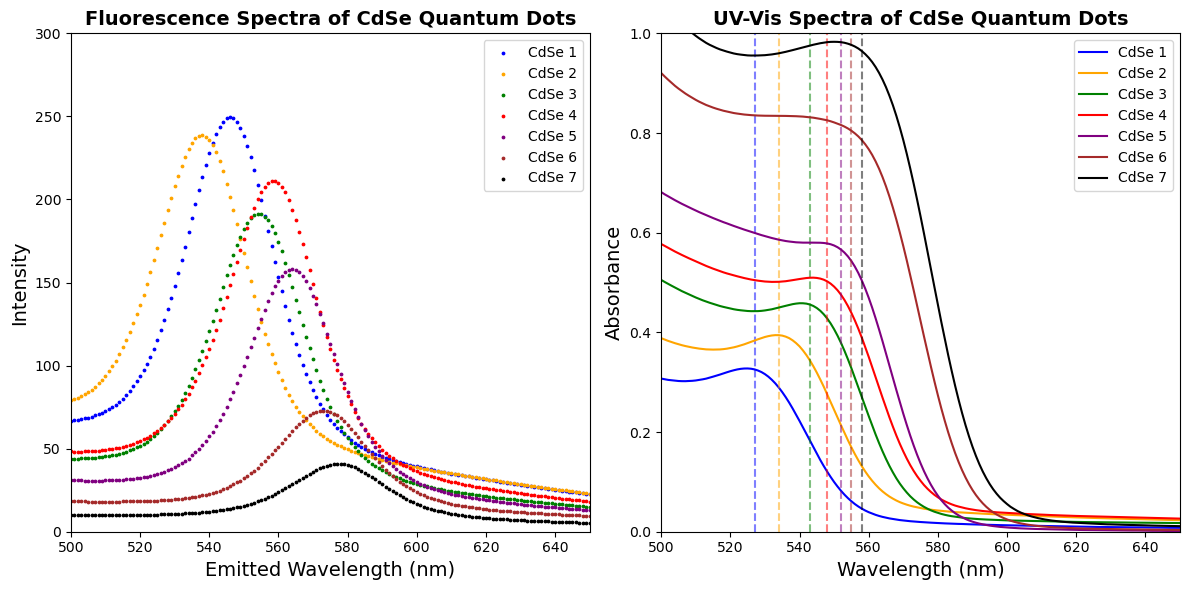

In [161]:
# Load all UV-Vis and fluorescence file paths
Fluofiles = glob.glob('ELJfl-*.txt')
UVfiles = glob.glob("CdSe*.csv")
colors = ['b', 'orange', 'g', 'r', 'purple', 'brown', 'black']

# Initialize lists to store fluorescence data
emitWavelen = [] # Emitted wavelength range
intensity = [] # Intensity of emitted wavelength
peakFlu = [] # Emitted wavelength of maximum intensity

# Initialize lists to store UV-Vis data
absWaveLen = []  # Absorbance wavelength range
absorbance = []  # Absorbance values
peakUV = []  # Peak absorbance wavelengths in specified ranges

# Extract UV wavelengths and their absorbance in meaningful range
plotWaveLen = []  
plotAbsorbance = []  

# Clean and Extract UV-Vis and fluoresence datasets
fluoData = clean_extract_data (Fluofiles, emitWavelen, 0, intensity, 1, "\t")
UVData = clean_extract_data (UVfiles, absWaveLen, 0, absorbance, 1, ",")

# Extract wavelength in 500–600 nm range and corresponding absorbance values
for i in range(len(UVfiles)):
    wl = []
    ab = []
    for w, a in zip(absWaveLen[i], absorbance[i]):
        if 500 <= w <= 650:  # Filter for 500–650 nm range
            wl.append(w)
            ab.append(a)
    plotWaveLen.append(wl)
    plotAbsorbance.append(ab)

# Define start and end values for peak extraction for each dataset
startEndVals = [(527, 600), (534, 600), (543, 600), (548, 600), (552, 600), (555, 600), (558, 600)]

# Extract peak absorbance wavelength within the specified ranges
for i in range(len(UVfiles)):
    start_val, end_val = startEndVals[i]
    subset_indices = [idx for idx, w in enumerate(plotWaveLen[i]) if start_val <= w <= end_val]
    subset_wavelengths = [plotWaveLen[i][idx] for idx in subset_indices]
    subset_absorbances = [plotAbsorbance[i][idx] for idx in subset_indices]
    # Find the wavelength at maximum absorbance within the range
    max_abs_idx = np.argmax(subset_absorbances)
    peakUVwl = subset_wavelengths[max_abs_idx]
    peakUV.append(peakUVwl)

# Plot Fluorescence and UV-Vis data 
plt.figure(figsize=(12, 6))

# Subplot 1: Fluorescence Spectra
plt.subplot(1, 2, 1)
for i in range(len(Fluofiles)):
    plt.scatter(emitWavelen[i], intensity[i], label=f'CdSe {i+1}', s=3, color=colors[i])
    peakFlu.append(emitWavelen[i][intensity[i].index(max(intensity[i]))])
plt.xlim(500, 650)
plt.ylim(0, 300)
plt.title("Fluorescence Spectra of CdSe Quantum Dots", fontsize=14, fontweight='bold')
plt.xlabel("Emitted Wavelength (nm)", fontsize=14)
plt.ylabel("Intensity", fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Subplot 2: UV-Vis Spectra
plt.subplot(1, 2, 2)
for i in range(len(UVfiles)):
    plt.plot(plotWaveLen[i], plotAbsorbance[i], label=f'CdSe {i+1}', linewidth=1.5, color=colors[i])
    plt.axvline(x=peakUV[i], color=colors[i], linestyle='--', alpha=0.5)
plt.xlim(500, 650)
plt.ylim(0, 1)
plt.title("UV-Vis Spectra of CdSe Quantum Dots", fontsize=14, fontweight='bold')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Absorbance", fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

## IV. Calculations of CdSe quantum dots' diameters

In [164]:
# Set up constant and list holder for radii calculations (both Fluorescence and UV-Vis)
enerGround = 1.751 * const.e # ground state energy (J), converted from 1.751 eV.
enerBulk = const.h * const.c / (709 * 1e-9) # energy of bulk materials (lamda_bulk = 709 nm)
m_h = 4.1 * 1e-31 # hole mass (kg)
corectFact = 10.62 
me = 0.13 # effective electron mass
mh = 0.45 # effective hole mass

### a. Fluorescence (Emission energy)
Emission energy can be calculated with known maximum emitted wavelength:

$$
E_{\text{emission}} = \frac{hc}{\lambda_{\text{max}}}
$$

The relationship between emission energy and ground state energy of quantum dots can be estimated as follows:

$$
E_{\text{emission}} = E_{\text{ground}} + \frac{h^2}{8r^2} \left( \frac{1}{m_e} + \frac{1}{m_h} \right) 
$$

Rearranging the above equation allows us to calculate the radius in the quadratic form with $x=\frac{1}{r}$

$$
\left( \frac{1}{r} \right)^2 \frac{h^2}{8} \left( \frac{1}{m_e} + \frac{1}{m_h} \right) + (E_{\text{ground}} - E_{\text{emission}}) = 0
$$]


In [167]:
# Lists to store FLuorescence data
enerExcitonList = [] # Exciton energy
diaFluoList = [] # CdSe diamaters list calculated from Fluorescence data

# Define constants in quadratic equation
a = (pow(const.h, 2)/8)*((1/const.m_e)+(1/m_h))

# Calculate exciton energy from transition energy and ground state energy
for w in peakFlu:
     enerTranst = const.h * const.c / (w * 1e-9)
     enerExcitonList.append(enerTranst - enerGround)

# Calculate diamaters based on Fluorescence data
for eEx in enerExcitonList:
    coef = [a, 0, - eEx] 
    dia = np.roots(coef)
    diaFluoList.append(round((1/dia[0])*1e9, 2))

### b. UV-Vis (Bandgap energy)

Energy gaps in bulk or nanomaterials can be calculated with known absorbance wavelength:

$$
E_g = \frac{hc}{\lambda_{\text{threshold}}} 
$$

The relationship between the energy gap of quantum dots and that of their bulk materials can be expressed as the Confinement Energy Equation as follows:

$$
E_g^{\text{nano}} = E_g^{\text{bulk}} + \frac{h^2}{8m_0r^2} \left( \frac{1}{m^*_e} + \frac{1}{m^*_h} \right) - \frac{1.8e^2}{4\pi \epsilon_0 \epsilon r} 
$$

Rearranging the above equation allows us to calculate the radius in the quadratic form with $x=\frac{1}{r}$

$$
\frac{h^2}{8m_0} \left( \frac{1}{m_e^*} + \frac{1}{m_h^*} \right) \left( \frac{1}{r} \right)^2 - \frac{1.8e^2}{4\pi \epsilon_0 \epsilon} \left( \frac{1}{r} \right) + \left( E_g^{\text{bulk}} - E_g^{\text{nano}} \right) = 0
$$


In [170]:
# Lists to store UV-Vis data
enerBGList = [] # energy of quantum-dots
diaUVisList = [] # CdSe radii list calculated from UV-Vis data

# Define constants in quadratic equation
a = (pow(const.h, 2)/8)*((1/me)+(1/mh))/(const.m_e)
b = -1.8*pow(const.e,2)/(4*const.pi*const.epsilon_0*corectFact)

# Calculate the difference of bandgap energy between bulk and nanomaterials
for w in peakUV:
    enerNano = const.h * const.c / (w * 1e-9)
    enerBGList.append(enerNano - enerBulk)

# Calculate diamaters based on UV-Vis data
for eBG in enerBGList: 
    coef = [a, b, - eBG] 
    dia = np.roots(coef)
    diaUVisList.append(round((1/dia[0])*1e9, 2))

## V. Comparisons of Data from Fluorescence and UV-Vis 

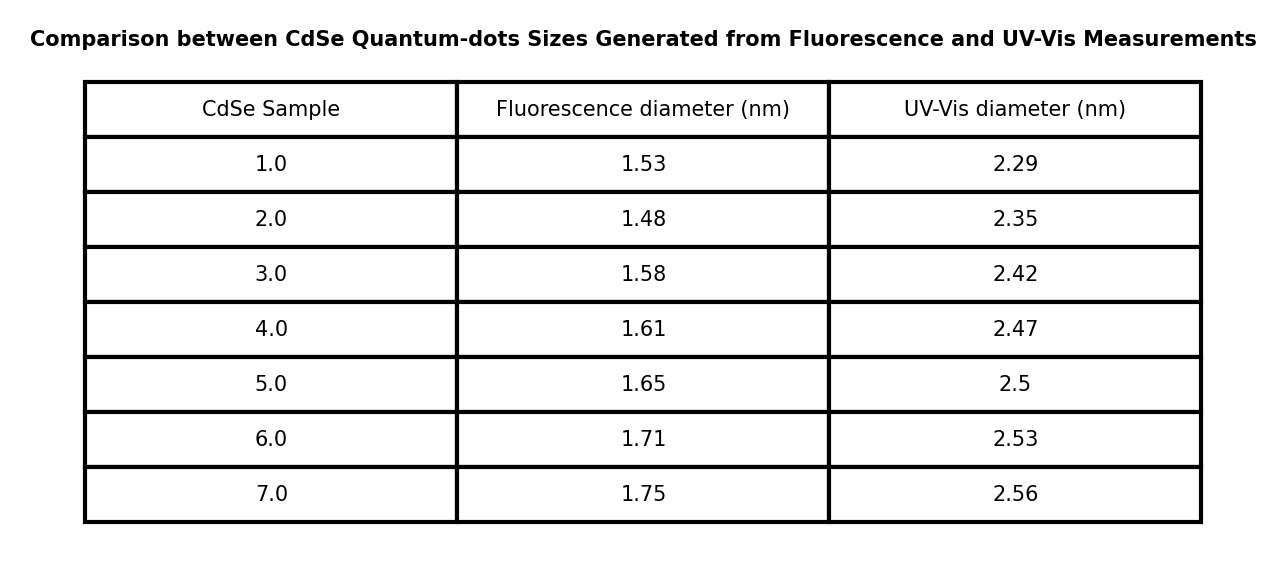

In [173]:
# Generate a comparison table for diamaters calculated by 2 approaches
dataSum = {"CdSe Sample": list(range(1,8)),
           "Fluorescence diameter (nm)": diaFluoList,
           "UV-Vis diameter (nm)": diaUVisList}      

df = pd.DataFrame(dataSum)

fig, ax = plt.subplots(figsize=(4, 2), dpi=300) 
ax.axis('off')
ax.set_title("Comparison between CdSe Quantum-dots Sizes Generated from Fluorescence and UV-Vis Measurements", fontsize=5, fontweight="bold")
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.scale(1.2, 1.1)   

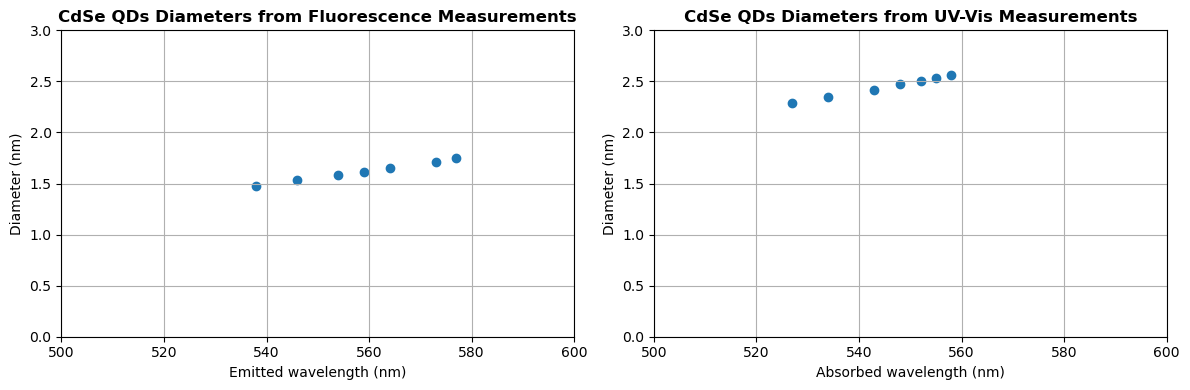

In [175]:
# Generate wavelengths vs. diameters plots for both approaches     
plt.figure(figsize=(12,4)) 
 
plt.subplot(1,2,1)
plt.scatter(peakFlu, diaFluoList)
plt.xlim(500,600)
plt.ylim(0,3)
plt.xlabel('Emitted wavelength (nm)')
plt.ylabel('Diameter (nm)')
plt.title('CdSe QDs Diameters from Fluorescence Measurements', fontweight='bold') 
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(peakUV, diaUVisList) 
plt.xlim(500,600)
plt.ylim(0,3)
plt.xlabel('Absorbed wavelength (nm)')
plt.ylabel('Diameter (nm)')
plt.title('CdSe QDs Diameters from UV-Vis Measurements', fontweight='bold') 
plt.grid(True)

plt.tight_layout()

## VI. Confinement Energy Equation: Diameter vs. Absorbed wavelength graph

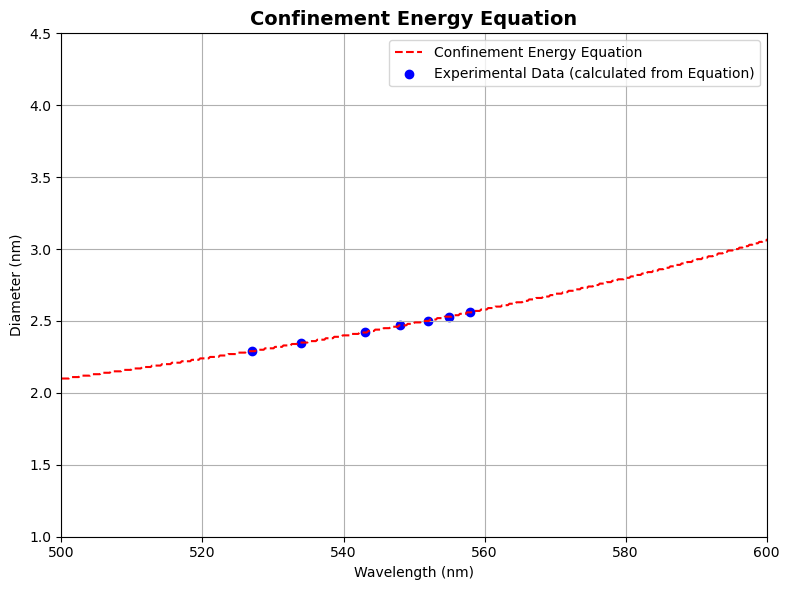

In [178]:
# Fitting data for confinement energy equation
wavelengths = np.linspace(450, 650, 1000) # wavelengths dataset
theoDiameter = [] # theoretical diamaters generated from Quantum confinement equation

for wl in wavelengths:
    d = QDs_diameter_from_UVABsorbance(me, mh, corectFact, enerBulk, wl)
    theoDiameter.append(round(1/d[0]*1e9, 2))
    
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, theoDiameter, label="Confinement Energy Equation", color='r', linestyle='--')
plt.scatter(peakUV, diaUVisList, label="Experimental Data (calculated from Equation)", color='b') 
plt.xlim(500,600)
plt.ylim(1,4.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Diameter (nm)")
plt.title("Confinement Energy Equation", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## VII. Generation of Mathematical Models

In this section, I propose two mathematical models to describe the growth dynamics of CdSe quantum dots, relating the reciprocal of the UV-Vis peak wavelength ($\frac{1}{w}$) to reaction time ($t$) and synthesis temperature ($T$). The first model is an empirical linear fit, while the second is a theoretically inspired model based on Arrhenius kinetics.

### A. Variables
The variables used in both models are defined as follows:

- w(nm): UV absorbed wavelength, representing the peak wavelength of the quantum dot's absorption spectrum.
- t(min): total reaction time, indicating the duration of the synthesis reaction.
- T(Kelvin): synthesis temperature.

### B. Empirical Model (Linear Fit)

The empirical model assumes a linear relationship between the reciprocal of the wavelength ($\frac{1}{w}$) and the natural logarithm of the ratio $\frac{t}{T}$:

$$ \frac{1}{w} =  a \cdot \ln \left( \frac{t}{T} \right) + b $$

Here, $a$ and $b$ are fitting parameters determined through linear regression.

#### Derivation of the Emperical Linear Model

The linear model was developed empirically based on observed trends in the data:

1. **Initial Observation**: Plotting $w$ against $t$ and $T$ revealed that a logarithmic relationship provided the highest $R^2$ values. Specifically, the variable $\ln \left( \frac{t}{T} \right)$ was found to capture the combined effect of time and temperature effectively.

2. **Reciprocal Transformation**: The reciprocal of the wavelength, $\frac{1}{w}$, was chosen as the dependent variable because it exhibited a clearer linear trend when plotted against $\ln \left( \frac{t}{T} \right)$, compared to $w$ directly. This transformation improved the fit for both experimental and reference datasets.

### C. Theoretical Model (Arrhenius-Inspired) 

The theoretical model incorporates physical principles of quantum dot growth, combining quantum confinement, diffusion-limited growth, and Arrhenius temperature dependence:

$$ \frac{1}{w} = a t^b e^{-\frac{c}{T}} + d $$

#### Derivation of the Arrhenius-Inspired Model

The Arrhenius-inspired model is derived from fundamental physical equations governing quantum dot growth:

**1. Quantum Confinement**:
   The UV-Vis peak wavelength $w$ is related to the bandgap energy $E_g$ of the quantum dot:

   $$ E_g = \frac{hc}{w} $$

   where $h$ is Planck’s constant and $c$ is the speed of light. Thus:

   $$ \frac{1}{w} = \frac{E_g}{hc} $$

   The bandgap depends on the quantum dot diameter $d$:

   $$ E_g = E_{g,\text{bulk}} + \frac{k}{d^2} $$

   where $E_{g,\text{bulk}}$ is the bulk bandgap and $k$ is a material-dependent constant. Substituting:

   $$ \frac{1}{w} = \frac{E_{g,\text{bulk}}}{hc} + \frac{k}{hc} \cdot \frac{1}{d^2} $$

   Let $d_0 = \frac{E_{g,\text{bulk}}}{hc}$ and $k' = \frac{k}{hc}$, so:

   $$ \frac{1}{w} = d_0 + k' \cdot \frac{1}{d^2} $$

**2. Diffusion-Limited Growth**:
   In diffusion-limited growth, the quantum dot diameter $d$ grows with time according to:

   $$ d \propto (D t)^{\frac{1}{3}} $$

   where $D$ is the diffusion coefficient, which follows an Arrhenius temperature dependence:

   $$ D = D_0 e^{-\frac{E_a}{k_B T}} $$

   Here, $D_0$ is a pre-exponential factor, $E_a$ is the activation energy, and $k_B$ is the Boltzmann constant. Combining:

   $$ d = k_1 t^{\frac{1}{3}} e^{-\frac{E_a}{3 k_B T}} $$

   where $k_1 = D_0^{\frac{1}{3}}$. Thus:

   $$ \frac{1}{d^2} = \frac{1}{k_1^2} t^{-\frac{2}{3}} e^{\frac{2 E_a}{3 k_B T}} $$

**3. Form of the Model**:
   Substituting into the expression for $\frac{1}{w}$:

   $$ \frac{1}{w} = d_0 + k' \cdot \frac{1}{k_1^2} t^{-\frac{2}{3}} e^{\frac{2 E_a}{3 k_B T}} $$

   To generalize, we introduce fitting parameters:
   - $a = k' \cdot \frac{1}{k_1^2}$,
   - $b$ replaces $-\frac{2}{3}$ to allow flexibility in the time exponent,
   - $c = \frac{2 E_a}{3 k_B}$,
   - $d = d_0$.

   This yields the final form:

   $$ \frac{1}{w} = a t^b e^{-\frac{c}{T}} + d $$

The parameters $a$, $b$, $c$, and $d$ are determined through fitting, providing a physically grounded model for quantum dot growth.

**4. Parameter Boundaries**:

The theoretical model, given by

$$ \frac{1}{w} = a t^b e^{-\frac{c}{T}} + d, $$

was fitted with parameter boundaries in `curve_fit` to improve stability when the initial fit was flat (variance of predicted reciprocal wavelength values < 0.0000000001 or R-squared < 0.1). The bounds, based on physical constraints, are: a in [0, 1], b in [-2, 0], c in [0, 5000], and d in [0, 0.01].

- **Parameter a**: This scaling factor for the growth term must be positive, estimated in the range [0, 1].
- **Parameter b**: The time exponent b, expected to be -2/3 for diffusion-limited growth, bounded to [-3, 0].
- **Parameter c**: Related to activation energy via

  $$ c = \frac{2 E_a}{3 k_B}, $$

  where $k_B = 8.617 \times 10^{-5}$ eV/K, c was bounded to [0, 5000]. With $E_a$ typically 20–50 kJ/mol, c around 2400 (for $E_a = 30$ kJ/mol) fits most materials (e.g., CdSe, PbS).

- **Parameter d**: Representing the bulk reciprocal wavelength,

  $$ d = \frac{E_{g,\text{bulk}}}{hc}, $$

  d was bounded to [0, 0.01]. For CdSe ($E_g \approx 1.74$ eV, wavelength ~712 nm, d ~0.0014 nm^-1), PbS (~0.41 eV, ~3024 nm, ~0.00033 nm^-1), and ZnSe (~2.7 eV, ~459 nm, ~0.0022 nm^-1), this range covers all materials while preventing unphysically large values.

## VIII. Display Graphs and Validate 10 Experimental Datasets with Two Mathematical Models

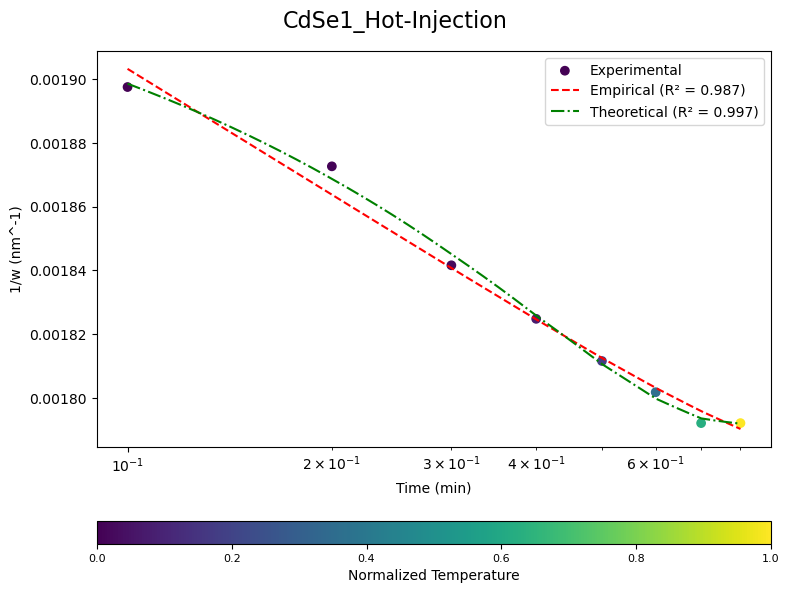

C:\Users\phuon\AppData\Local\Temp\ipykernel_22204\2479350798.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, maxfev=10000)


Theoretical Model fit for CdSe2_Hot-Injection is flat (variance=4.70e-38, R^2=0.00). Retrying with initial guesses and bounds.


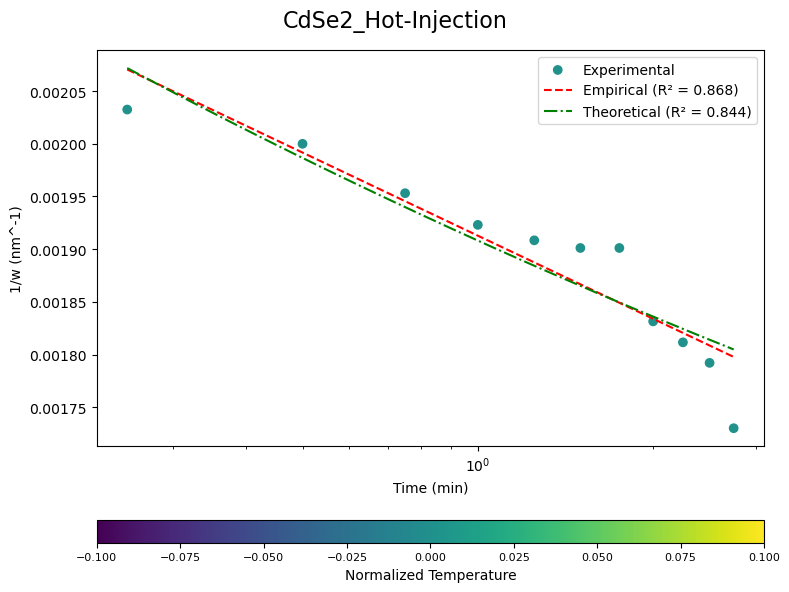

C:\Users\phuon\AppData\Local\Temp\ipykernel_22204\2479350798.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, maxfev=10000)


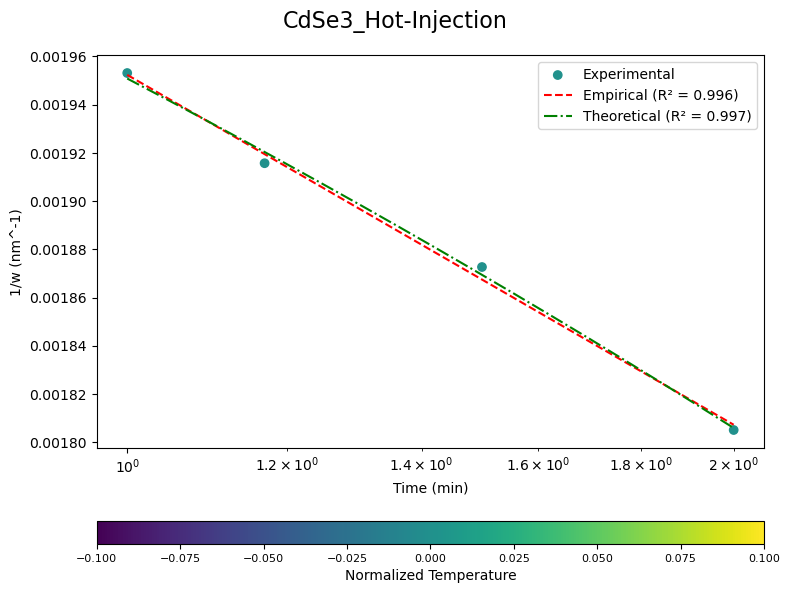

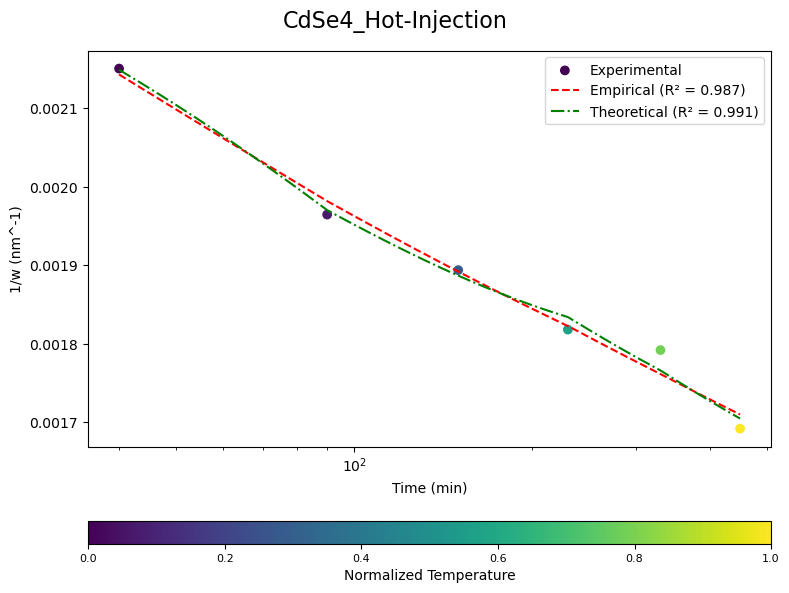

Error fitting Theoretical Model for CdSe5_Hot-Injection: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


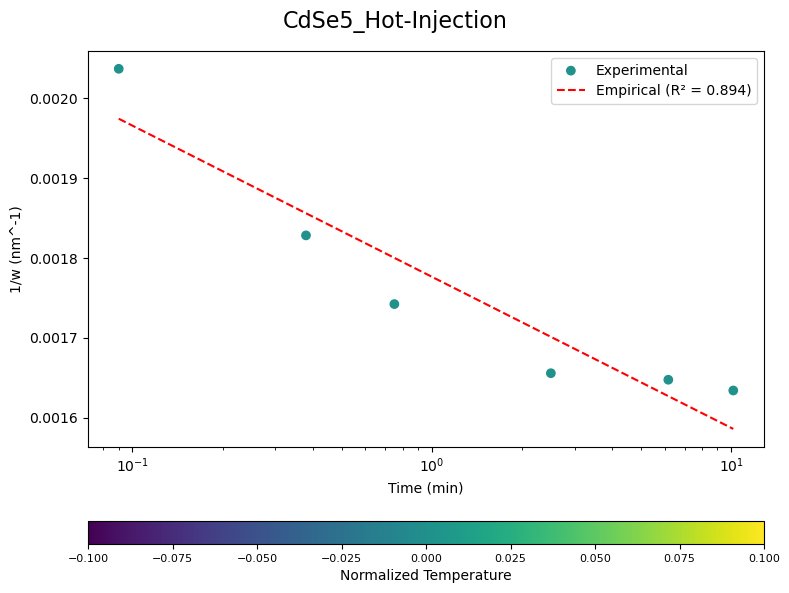

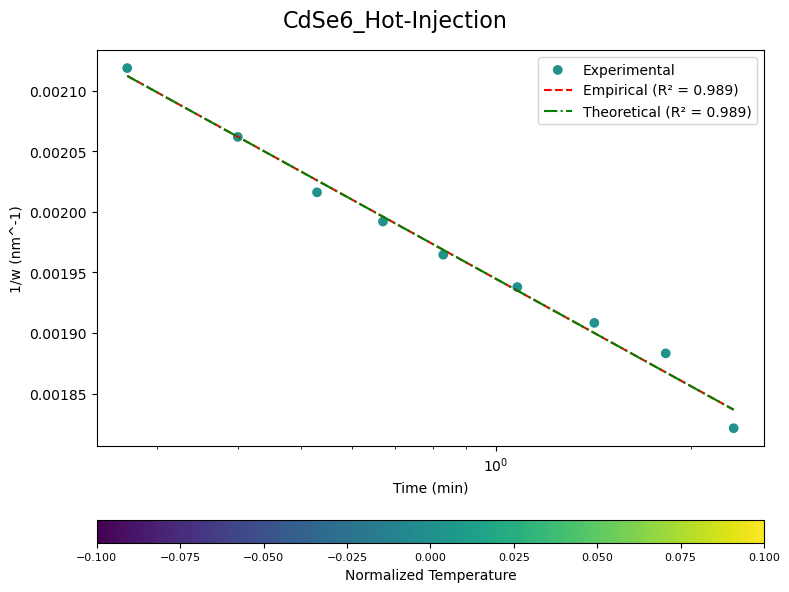

Error fitting Theoretical Model for CdSe7_Hot-Injection: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


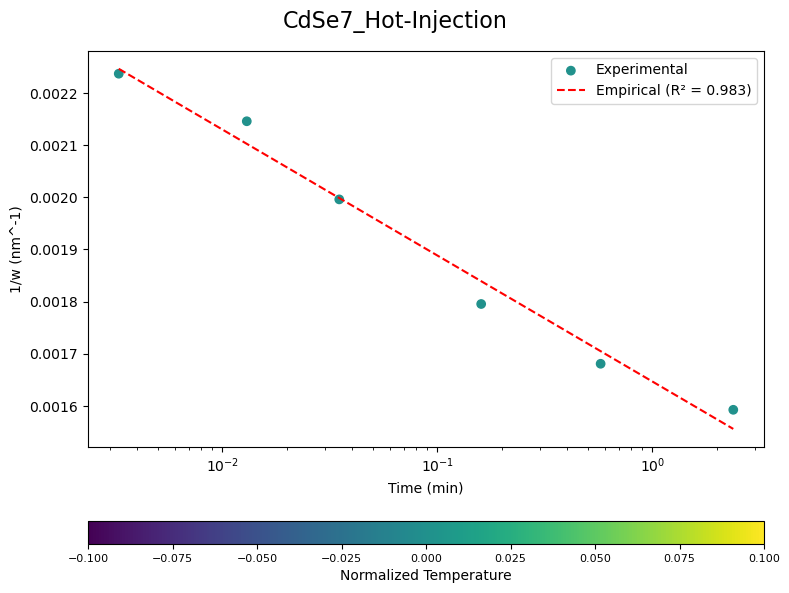

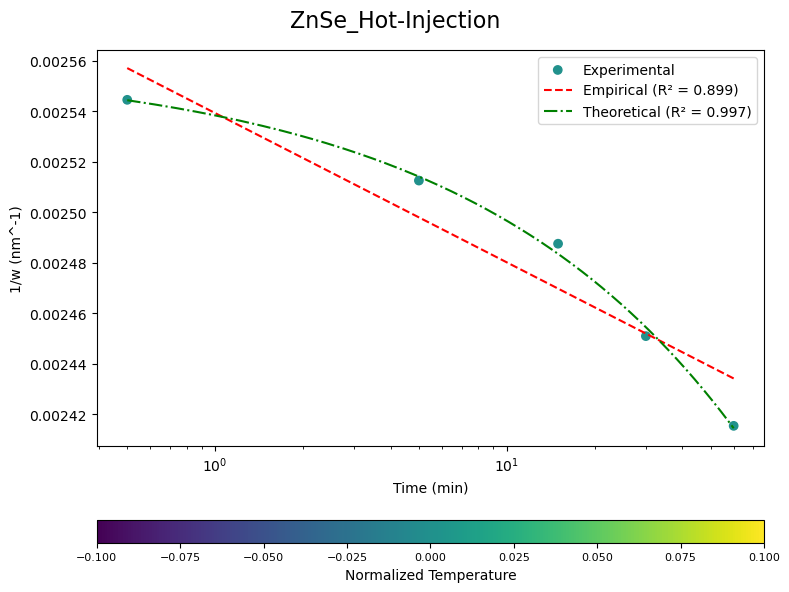

Error fitting Theoretical Model for CdTe_Hot-Injection: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


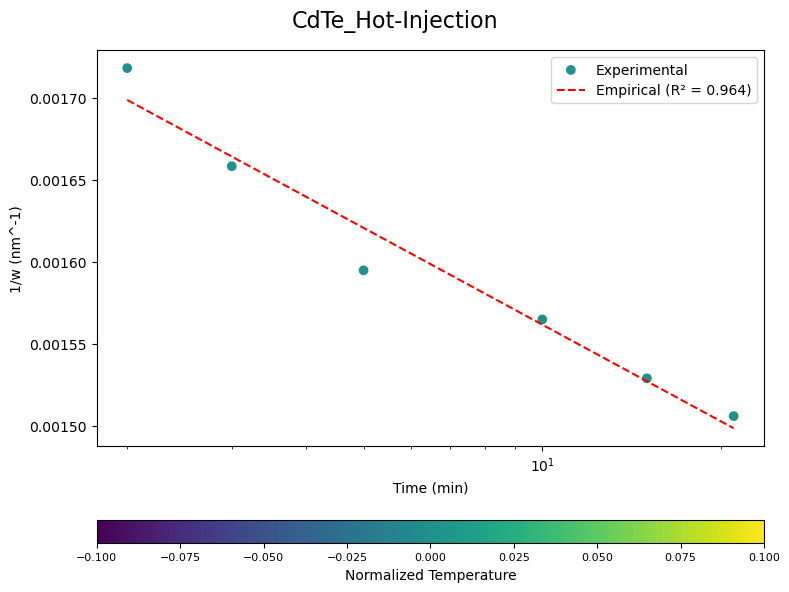

C:\Users\phuon\AppData\Local\Temp\ipykernel_22204\2479350798.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, maxfev=10000)
C:\Users\phuon\AppData\Local\Temp\ipykernel_22204\2479350798.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, bounds=bounds, maxfev=10000)


Theoretical Model fit for CdS_Hot-Injection is flat (variance=0.00e+00, R^2=0.00). Retrying with initial guesses and bounds.


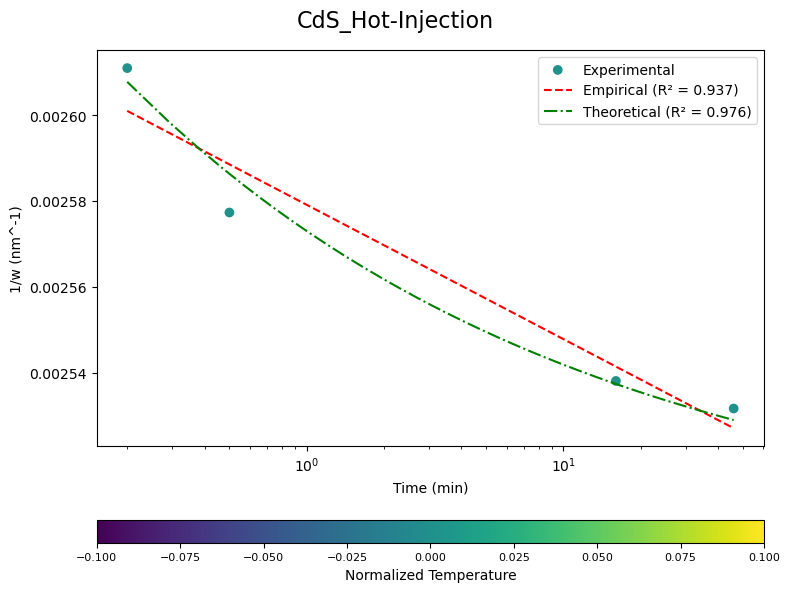

In [197]:
# Initialize results list to store fitting metrics
results = []

# Loop through each dataset
for dataset_name, data in datasets.items():
    t = np.array(data['t'])
    T = np.array(data['T'])
    w = np.array(data['w'])
    inv_w = 1 / w
    xdata = (t, T)

    # Initialize results for each model
    r2_emp = np.nan
    r2_theo = np.nan
    popt_emp = [np.nan, np.nan]
    popt_theo = [np.nan, np.nan, np.nan, np.nan]

    # Fit Empirical Model (2 parameters, requires >= 2 points)
    num_points = len(t)
    if num_points >= 2:
        try:
            popt_emp, _ = curve_fit(empirical_model, xdata, inv_w, maxfev=10000)
            y_pred_emp = empirical_model(xdata, *popt_emp)
            r2_emp = r2_score(inv_w, y_pred_emp)
        except Exception as e:
            print(f"Error fitting Empirical Model for {dataset_name}: {e}")

    # Fit Theoretical Model (4 parameters, requires >= 4 points)
    if num_points >= 4:
        try:
            # Initial fit without bounding
            popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, maxfev=10000)
            y_pred_theo = theoretical_model(xdata, *popt_theo)
            r2_theo = r2_score(inv_w, y_pred_theo)
            # Check for flat fit:
            variance_pred = np.var(y_pred_theo)
            if variance_pred < 1e-10 or r2_theo < 0.1:
                print(f"Theoretical Model fit for {dataset_name} is flat (variance={variance_pred:.2e}, R^2={r2_theo:.2f}). Retrying with initial guesses and bounds.")
                bounds = ([0, -2, 0, 0], [1, 0, 5000, 0.01])
                popt_theo, _ = curve_fit(theoretical_model, xdata, inv_w, bounds=bounds, maxfev=10000)
                y_pred_theo = theoretical_model(xdata, *popt_theo)
                r2_theo = r2_score(inv_w, y_pred_theo)
        except Exception as e:
            print(f"Error fitting Theoretical Model for {dataset_name}: {e}")
    else:
        print(f"Skipping Theoretical Model for {dataset_name}: Not enough data points ({num_points} < 4)")

    # Store results
    results.append({
        'Dataset': dataset_name,
        'Empirical R^2': round(r2_emp, 2),
        'Emp a': np.format_float_scientific(popt_emp[0], precision=3),
        'Emp b': np.format_float_scientific(popt_emp[1], precision=3),
        'Theoretical R^2': round(r2_theo, 2),
        'Theo a': np.format_float_scientific(popt_theo[0], precision=3),
        'Theo b': np.format_float_scientific(popt_theo[1], precision=3),
        'Theo c': np.format_float_scientific(popt_theo[2], precision=3),
        'Theo d': np.format_float_scientific(popt_theo[3], precision=3),
    })

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))  # Single plot
    fig.suptitle(f'{dataset_name}', fontsize=16)

    # Normalize temperatures for color mapping
    T_norm = (T - min(T)) / (max(T) - min(T)) if max(T) != min(T) else np.zeros_like(T)

    # Plot experimental data
    scatter = ax.scatter(t, inv_w, c=T_norm, cmap='viridis', label='Experimental')

    # Plot Empirical Fit
    if not np.isnan(r2_emp):
        t_fine, inv_w_fine = generate_fitted_curve(empirical_model, t, T, popt_emp)
        ax.plot(t_fine, inv_w_fine, 'r--', label=f'Empirical (R² = {r2_emp:.3f})')

    # Plot Theoretical Fit
    if not np.isnan(r2_theo):
        t_fine, inv_w_fine = generate_fitted_curve(theoretical_model, t, T, popt_theo)
        ax.plot(t_fine, inv_w_fine, 'g-.', label=f'Theoretical (R² = {r2_theo:.3f})')

    # Set labels and scales
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('1/w (nm^-1)')
    ax.set_xscale('log')
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax, label='Normalized Temperature', orientation='horizontal', pad=0.15, fraction=0.05, aspect=30)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()


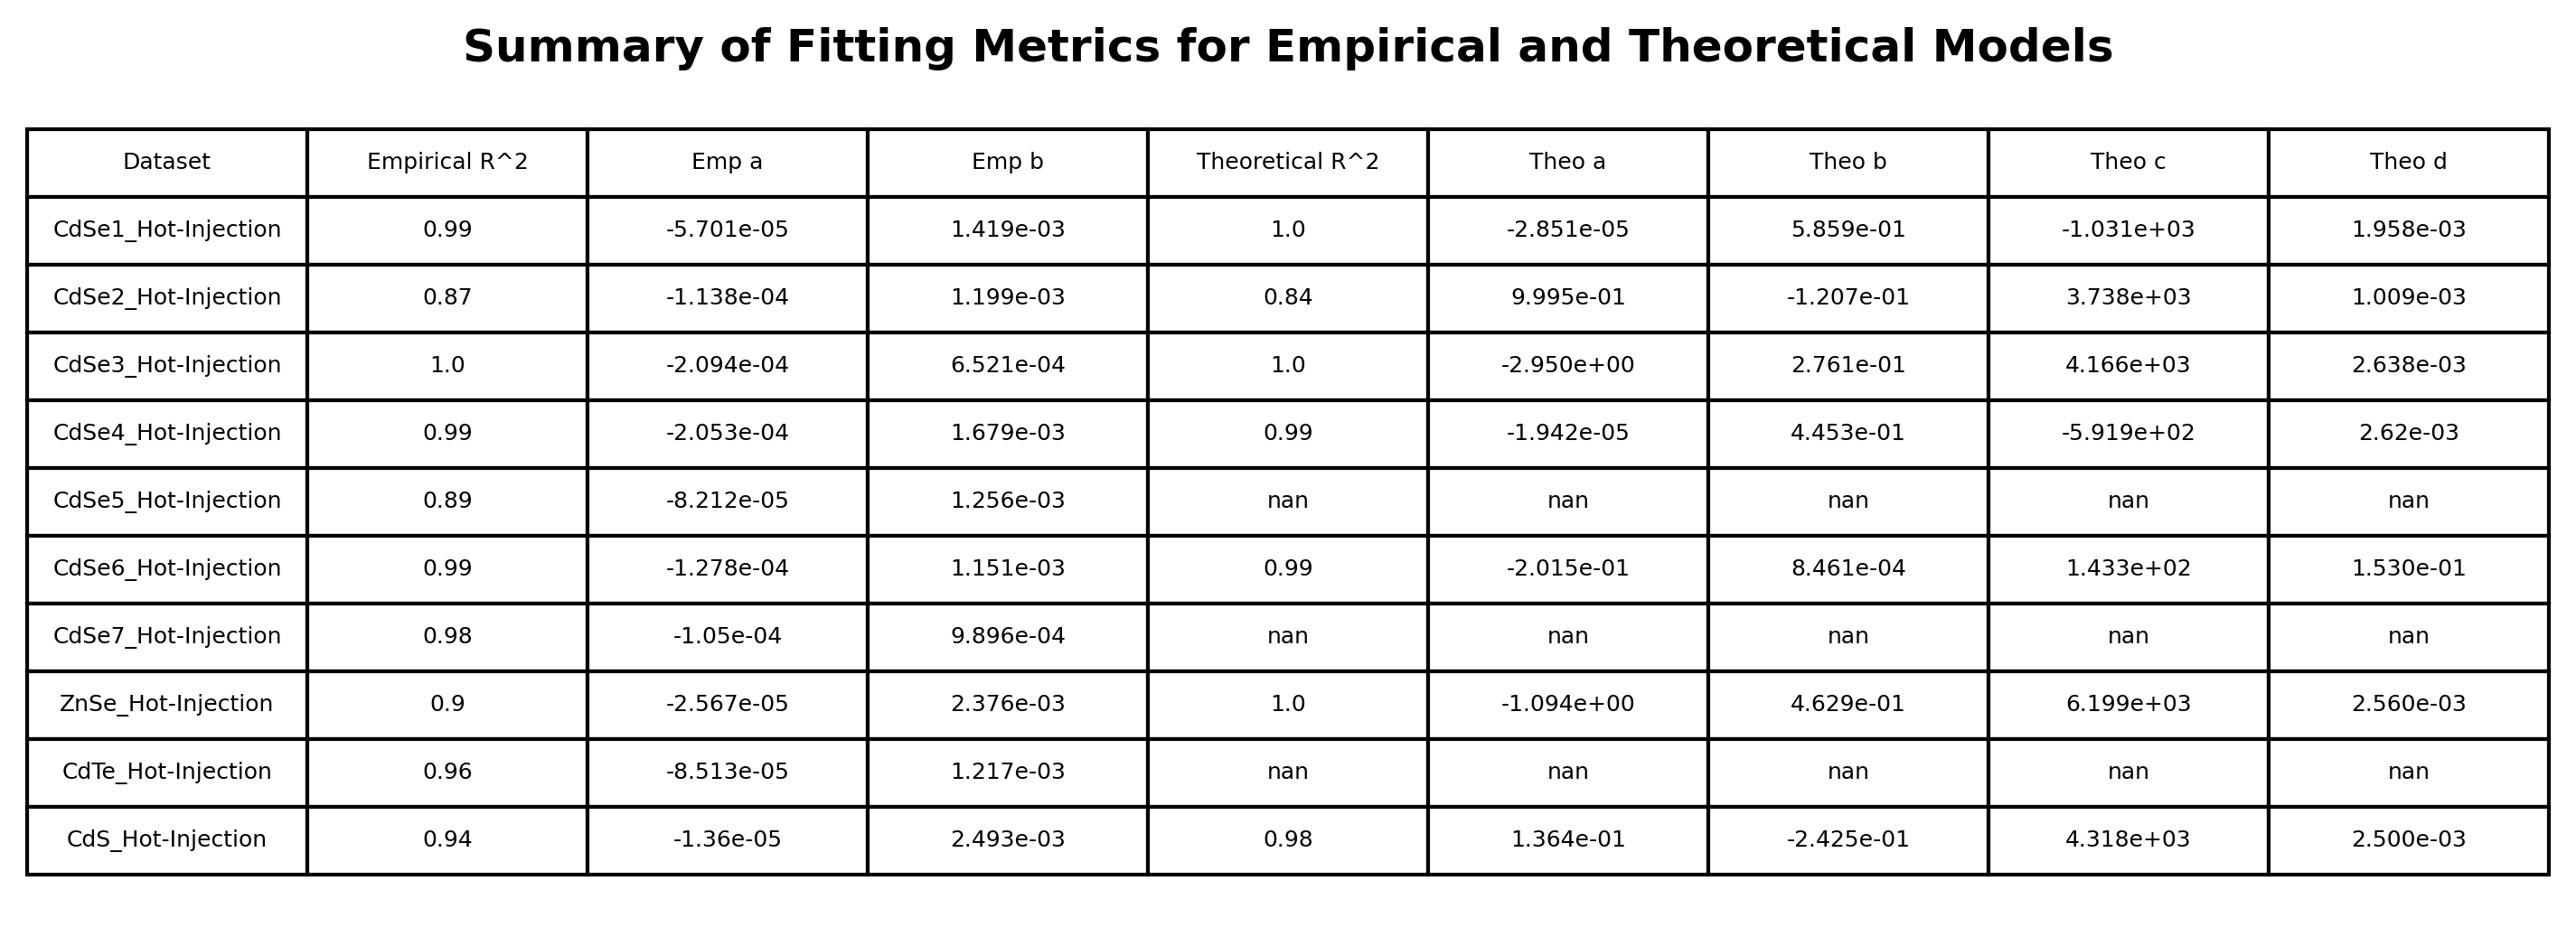

In [199]:
# Create and print results DataFrame
results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 4), dpi=300) 
ax.axis('tight')
ax.axis('off')
ax.set_title("Summary of Fitting Metrics for Empirical and Theoretical Models", fontsize=12, fontweight="bold")
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.scale(1.2, 1.5)    

## IX. Discussions
### a. Difference between UV-Vis and Fluorescence Spectroscopy for Determining CdSe QDs Sizes
Both fluorescence and UV-Vis data display the proportional relationship between emission/absorbance wavelength and QDs' radius size. While both approaches simplify the the calculation of exciton energy by treating it as a particle in a box, and that ground state energy of CdSe QDs and energy gap of CdSe bulk materials are relatively close to each other, the particle sizes calculated by UV-Vis data are much higher. This is possibly caused by two reasons:

(1) Absoption wavelengths in UV-Vis are extrapolated threshold values, which can be higher than the actual threshold values. This means that diameters calculated from UV-Vis might be overestimated. 

(2) Column interaction is not involved in the fluorescence model: free mass (instead of effective mass) of electron and hole is used for calculation, which makes the its first coefficient (a) smaller. This means that diameters calculated from Fluorescence might be underestimated.

However, the fact that fluorescence model does not take Column interactions (including effective mass and binding energy) and its dependence on the chosen excited wavelength makes UV-Vis a more reliable approach to calculate quantum dots' size.

### b. Model Performance

All models were applied to quantum dot (QD) datasets (CdSe, CdTe, ZnSe, and CdS) with hot-injection synthesis, achieving high $R^2$ values (mostly $> 0.90$). The linear empirical model, defined as
$$
\frac{1}{w} = b \ln \left( \frac{t}{T} \right) + c,
$$
with 2 parameters, effectively captured the relationship between $\frac{1}{w}$ and $\ln \left( \frac{t}{T} \right)$, fitting all 10 datasets. It excelled in most datasets, such as CdSe1_Hot-Injection, CdSe3_Hot-Injection, CdSe4_Hot-Injection, CdSe6_Hot-Injection, CdSe7_Hot-Injection, CdTe_Hot-Injection, CdS_Hot-Injection, balancing simplicity and versatility. The Arrhenius-inspired model,
$$
\frac{1}{w} = a t^b e^{-\frac{c}{T}} + d,
$$
with 4 parameters, provided a physically grounded framework, mostly achieving comparable or higher $R^2$ compared to the linear counterpart, except for  CdSe2_Hot-Injection. However, it failed for CdSe5_Hot-Injection and CdSe7_Hot-Injection due to convergence issues from wide time ranges. 

### c. Limitations and Challenges

The empirical linear model lacks physical interpretability, limiting mechanistic insights. While the Arrhenius-inspired model assumes diffusion-limited growth, which may not apply universally, and requires $\geq 4$ points, making it unreliable for small datasets.

## X. Conclusion

The linear empirical model demonstrated versatility, fitting all 10 QD datasets with most having $R^2 > 0.90$, while the Arrhenius-inspired and modified theoretical models offered physical insights but struggled with convergence. The modified theoretical model excelled with sufficient data ($R^2 > 0.96$), but risked overfitting in smaller datasets. Limitations included the empirical model’s lack of physical interpretability, the Arrhenius model’s assumptions, and dataset quality issues. Future work should focus on higher-resolution datasets, larger sample sizes, and alternative functional forms to better capture complex QD growth dynamics accuracy.

## References

1. Jasieniak, J.; Mulvaney, P. From Cd-Rich to Se-Rich $−$ The Manipulation of CdSe Nanocrystal Surface Stoichiometry. *J. Am. Chem. Soc.* **2009**, *131* (8), 2841–2849. DOI: [10.1021/jp906827m](https://doi.org/10.1021/jp906827m).

2. Ali, M. E.; Shazly, M. A. S.; Afify, A. M. Characterization of CdSe-Nanocrystals Used in Semiconductors for Aerospace Applications: Production and Optical Properties. *Egypt. J. Pet.* **2014**, *23* (1), 41–45. DOI: [10.1016/j.ejpe.2014.02.002](https://doi.org/10.1016/j.ejpe.2014.02.002).

3. Donegá, C. M. Synthesis and Properties of Colloidal Semiconductor Nanocrystals. In *Nanotechnology in Catalysis: Applications in the Chemical Industry, Energy Development, and Environment Protection*; Sels, B., Van de Voorde, M., Eds.; Wiley-VCH: Weinheim, Germany, 2017; pp 77–104. DOI: [10.5772/46059](https://doi.org/10.5772/46059).

4. Zlateva, G.; Zhelev, Z.; Bakalova, R.; Kanno, I. Precise Size Control and Synchronized Synthesis of Six Colors of CdSe Quantum Dots in a Slow-Increasing Temperature Gradient. *Inorg. Chem.* **2007**, *46* (16), 6212–6214. DOI: [10.1021/ic062045s](https://doi.org/10.1021/ic062045s).

5. Qu, L. H.; Peng, X. G. Control of Photoluminescence Properties of CdSe Nanocrystals in Growth. *J. Am. Chem. Soc.* **2002**, *124* (9), 2049–2055. DOI: [10.1021/ja011473f](https://doi.org/10.1021/ja011473f).

6. Boatman, E. M.; Lisensky, G. C.; Nordell, K. J. A Safer, Easier, Faster Synthesis for CdSe Quantum Dot Nanocrystals. *J. Chem. Educ.* **2005**, *82* (11), 1697–1699. DOI: [10.1021/ed082p1697](https://doi.org/10.1021/ed082p1697).

7. Bullen, C. R.; Mulvaney, P. Nucleation and Growth Kinetics of CdSe Nanocrystals in Octadecene. *Nano Lett.* **2004**, *4* (12), 2303–2307. DOI: [10.1021/nl035211r](https://doi.org/10.1021/nl035211r).

8. Pal, B.; Kundu, A.; Banerjee, A.; Saha, S.; Brahme, N.; Pal, S.; Bera, A. Temperature-Dependent Photoluminescence Study of CdSe Quantum Dots for Their Potential Application in High-Performance Devices. *Sci. Rep.* **2024**, *14*, 13804. DOI: [10.1038/s41598-024-64995-5](https://doi.org/10.1038/s41598-024-64995-5).

9. Peng, X.; Wickham, J.; Alivisatos, A. P. Kinetics of II-VI and III-V Colloidal Semiconductor Nanocrystal Growth: "Focusing" of Size Distributions. *J. Am. Chem. Soc.* **1998**, *120* (21), 5343–5344. DOI: [10.1021/ja003633m](https://doi.org/10.1021/ja003633m).
